In [8]:
import os
from pathlib import Path

cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

In [9]:
import pandas as pd
from mllm_emotion_classifier.utils import (
    add_fairness_metrics_to_df,
    # plot_fairness_vs_hparam,
    # plot_fairness_by_emotion,
    FigureCollector,
)

from mllm_emotion_classifier.utils.line_plot_separated import plot_fairness_vs_hparam
from EmoBox.EmoBox import EmoDataset

In [10]:
sensitive_attr_dict = {
    'iemocap': ['gender'],
    'cremad': ['gender', 'age', 'ethnicity'], #, 'race'],
    'emovdb': ['gender'],
    'tess': ['agegroup'],
    'ravdess': ['gender'],
    'esd': ['gender'],
    'meld': ['gender'],
}

In [11]:
hparam = 'temperature' # or 'top_p'
assert hparam in ['temperature', 'top_p'], "hparam must be either 'temperature' or 'top_p'"

dataset = 'meld'  # 'cremad', 'iemocap', 'emovdb', 'tess' (agegroup), 'meld'
fold = None # Set to an integer fold number if needed, else None to aggregate all folds
sensitive_attrs = sensitive_attr_dict[dataset]  # gender, age, ethnicity, race
model = 'qwen2-audio-instruct'

metadata_dir = Path('EmoBox/data/')
dataset_path = metadata_dir / dataset
n_folds = len([d for d in dataset_path.iterdir() if d.is_dir() and d.name.startswith("fold_")]) if dataset != 'esd' else 2
out_dir = Path('outputs-2') / "temperature_runs" if hparam == 'temperature' else Path('outputs-2') / "topp_runs"

test = EmoDataset(dataset, './', metadata_dir, fold=1, split="test")
emotions = set(test.label_map.values())

if fold is None:
    dfs = []
    for f in range(1, n_folds + 1):
        results_csv = out_dir / model / dataset / f'fold_{f}.csv'
        df_fold = pd.read_csv(results_csv)
        dfs.append(df_fold)
    df = pd.concat(dfs, ignore_index=True)
else:
    results_csv = out_dir / model / dataset / f'fold_{fold}.csv'
    df = pd.read_csv(results_csv)

print(len(df), "rows")
df.head(5)

using official valid data in EmoBox/data/meld/fold_1/meld_valid_fold_1.jsonl
load in 9988 samples, only 9988 exists in data dir EmoBox/data
load in 2610 samples, only 2156 exists in data dir EmoBox/data
load in 1108 samples, only 952 exists in data dir EmoBox/data
Num. training samples 9988
Num. valid samples 952
Num. test samples 2156
Using label_map {'neutral': 'Neutral', 'joy': 'Happy', 'sadness': 'Sad', 'surprise': 'Surprise', 'disgust': 'Disgust', 'anger': 'Angry', 'fear': 'Fear'}
60 rows


,run,dataset,fold,model,prompt,temperature,valid_rate,global_f1_macro,global_f1_weighted,global_accuracy_unweighted,...,language_statistical_parity,language_Angry_equal_opportunity,language_Disgust_equal_opportunity,language_Fear_equal_opportunity,language_Happy_equal_opportunity,language_Neutral_equal_opportunity,language_Sad_equal_opportunity,language_Surprise_equal_opportunity,language_equal_opportunity,language_overall_accuracy_equality
0,0,meld,1,qwen2-audio-instruct,user_labels,0.0001,1.0,0.2576,0.3789,0.3450,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,meld,1,qwen2-audio-instruct,user_labels,0.3000,1.0,0.3037,0.4340,0.4097,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,meld,1,qwen2-audio-instruct,user_labels,0.7000,1.0,0.2578,0.3235,0.3594,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,meld,1,qwen2-audio-instruct,user_labels,1.0000,1.0,0.2522,0.4043,0.3075,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,meld,1,qwen2-audio-instruct,user_labels,1.2000,1.0,0.2079,0.3414,0.2703,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
test[0]

/nfs/home/dasaro/research/FairMLLM-Emotion-Recognition/EmoBox/EmoBox/EmoDataset.py:200: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(wav_path, sr=None, mono=False)
/nfs/home/dasaro/research/FairMLLM-Emotion-Recognition/.venv/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


{'key': 'meld-dia0_utt1-test',
 'audio': array([-1.9778842e-04, -1.3071824e-04,  9.4887742e-05, ...,
         4.1938017e-04,  2.6770466e-04,  6.8298017e-05],
       shape=(108203,), dtype=float32),
 'label': 'Angry',
 'gender': 'Female',
 'age': 27,
 'language': 'English'}

In [13]:
emotions

{'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'}

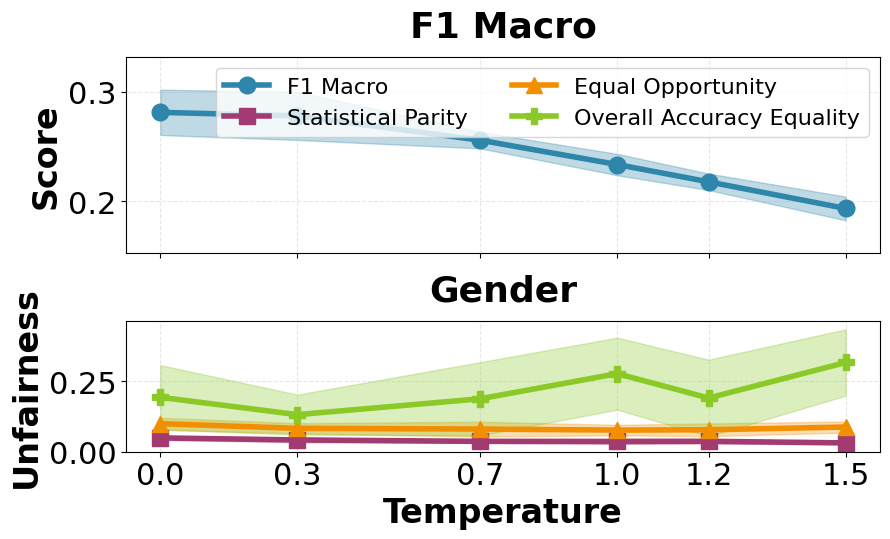

In [14]:
show_std = True
fold = fold if fold is not None else 'all'
os.makedirs(out_dir / 'figures', exist_ok=True)
outpath = out_dir / 'figures' / f'{dataset}_line_fold_{fold}.png'

plot_fairness_vs_hparam(
    df,
    hparam,
    [f'statistical_parity', f'equal_opportunity', f'overall_accuracy_equality'],
    sensitive_attrs,
    model,
    dataset,
    fold,
    show_std=show_std,
    output_path=outpath,
)